# Programming Assignment 4: Recurrent Neural Networks

## PACKAGE IMPLEMENTATION

Download the necessary libraries

In [1]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
import math

## DATA LOADING AND DATA PREPARATION

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Get the training and testing datasets
# First need to transform the images into a suitable form (normalization) and convert them to a Tensor
# DataLoader class
transform = transforms.Compose([
        transforms.ToTensor(),
    ])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, (50000,10000)) # Divide the whole data into training (50,000 images), validation (10,000 images)

dataloaders = {}
# First I import the "full" dataset without dividing it into batches. I'll do it during the training of the model
batch_size = 512
dataloaders['train'] = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
dataloaders['validation'] = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

# train_features, train_labels = next(iter(dataloaders['train']))
test_features, test_labels = next(iter(dataloaders['test']))
test_features = test_features.to(device)
test_labels = test_labels.to(device)

val_features, val_labels = next(iter(dataloaders['validation']))
val_features = val_features.to(device)
val_labels = val_labels.to(device)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.17MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## CHECKS

In [ ]:
ds_type = 'validation'
for images, labels in dataloaders[ds_type]:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([512, 1, 28, 28])
torch.Size([512])


# Functions

In [5]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs=5, device='cpu'):
  """
  Train the model given the data. For num_epochs of time the model is trained, which
  means that, based on the backward propagation, the weights (params) are adjusted.
  The loss function is also saved so to understand if the model is actually learning well.
  :param:
  model: desired network to be trained
  dataloader: torch loader of the training data (inputs and labels)
  loss_fn: loss function to use during the training of the network
  optimizer: optimizer to use during the training of the network
  num_epochs: for how many epochs the model will be trained?
  device: in this case just cpu is available since I'm working with numpy

  :return:
  train_loss: loss function for training data
  val_loss: loss function for validation data
  val_accuracy: accuracy of the model on validation data
  """
  train_loss = []
  val_loss = []
  val_accuracy = []

  for epoch in range(epochs):
    for i, (images, labels) in enumerate(dataloader):
      images = images.to(device)
      labels = labels.to(device)
      # Make input suitable for the model
      images = images.reshape(-1, 28, 28)
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      train_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    iteration = 0
    tempvalloss = 0
    correctval = 0

    # At the end of the epoch I compute the loss and the accuracy on the validation dataset
    for images, labels in dataloaders['validation']:
      images = images.to(device)
      labels = labels.to(device)
      images = images.reshape(-1, 28, 28)
      outputs = model(images)
      # Getting the loss
      # I sum and compute the iterations to get the effective loss function at the end of the epoch
      loss = loss_fn(outputs, labels)
      iteration += 1
      tempvalloss += loss.item()

      # Gettin the accuracy
      _, predicted = torch.max(outputs.data, 1)
      correctval += (predicted == labels).sum().item()

    val_loss.append(tempvalloss/iteration)
    val_accuracy.append(correctval/100)
    print(f'Epoch [{epoch+1}/{epochs}] - Validation loss: {val_loss[-1]:.4f}, Validation accuracy: {val_accuracy[-1]}%')
  return train_loss, val_loss, val_accuracy

In [6]:
def plotter(training_loss, validation_loss, validation_accuracy, model_type):
  """
  Plot the values resulting from the train_model() function.
  :param:
  training_loss: loss function for training data
  validation_loss: loss function for validation data
  validation_accuracy: accuracy of the model on validation data
  model_type: simple string to indicate the model for the plot's title

  :return:
  """
  plt_1 = plt.figure(figsize=(8, 5))
  plt.figure(1)
  xtrainloss=np.arange(len(training_loss))
  plt.plot(xtrainloss,training_loss)
  plt.xlabel('Number of Iterations')
  plt.ylabel('Training Loss')
  plt.title(f'Training Loss vs Iterations for {model_type}')

  plt_1 = plt.figure(figsize=(8, 5))
  plt.figure(2)
  plt.plot(range(1,len(validation_loss)+1),validation_loss,marker='o')
  plt.xticks(np.arange(1, epochs+1, 1))
  plt.xlabel('Number of Epochs')
  plt.ylabel('Validation Loss')
  plt.title(f'Validation Loss vs Epochs for {model_type}')

  plt_1 = plt.figure(figsize=(8, 5))
  plt.figure(3)
  plt.plot(range(1,len(validation_accuracy)+1),validation_accuracy,marker='o')
  plt.xticks(np.arange(1, epochs+1, 1))
  plt.xlabel('Number of Epochs')
  plt.ylabel('Validation Accuracy')
  plt.title(f'Validation Accuracy vs Epochs for {model_type}')
  plt.show()

In [7]:
def evaluate_model(model, dataloader, device='cpu'):
  """
  No return. Just print the accuracy of model in the given test dataset.
  :param:
  model: desired network to be tested
  dataloader: torch loader of the test data (inputs and labels)

  :return:
  """
  correct = 0
  total = 0

  # Set the model to evaluation mode
  model.eval()

  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      images = images.reshape(-1, 28, 28)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = correct / total
  print('Accuracy on test set: {:.2f}%'.format(100 * accuracy))

# 1 MNIST classification using RNN
RNN treats each row of pixels (28 values) as a sequential input, where it processes one row at a time across the entire image, capturing sequential relationships across the rows. The model learns (hopefully) the spatial dependencies on the image.

In [ ]:
class myRNN(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10, activation='tanh'): # Each input vector to the RNN represents a single ROW of pixels
    super(myRNN, self).__init__()
    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, nonlinearity=activation, device=device) # Start with a network with hidden state size of 128
    self.layer2 = nn.Linear(hidden_size, output_size) # Let the output activation be linear
    self.device = device
    self.hidden_size = hidden_size

  def forward(self, X):
    # print(X.shape) torch.Size([512, 28, 28])
    X = X.permute(1, 0, 2).to(self.device)
    # print(X.shape) torch.Size([28, 512, 28]) --> expected input: [sequence_length, batch_size, input_size]
    # Initialize the hidden layer
    hiddenlayer = torch.zeros(1, X.size(1), self.hidden_size, device=self.device)
    _, hiddenlayer = self.rnn(X, hiddenlayer) # return output, h_t
    out = self.layer2(hiddenlayer) # let the output activation be linear
    return out.reshape(-1, 10)

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

In [ ]:
criterion1 = nn.CrossEntropyLoss() # already implement softmax()
model1 = myRNN(hidden_size=128).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [ ]:
train_loss, val_loss, val_accuracy = train_model(model1, dataloaders['train'], criterion1, optimizer1, epochs, device=device)

Epoch [1/10] - Validation loss: 1.1483, Validation accuracy: 60.23%
Epoch [2/10] - Validation loss: 0.8774, Validation accuracy: 69.61%
Epoch [3/10] - Validation loss: 0.7255, Validation accuracy: 75.4%
Epoch [4/10] - Validation loss: 0.5946, Validation accuracy: 80.95%
Epoch [5/10] - Validation loss: 0.4633, Validation accuracy: 85.97%
Epoch [6/10] - Validation loss: 0.4062, Validation accuracy: 87.88%
Epoch [7/10] - Validation loss: 0.3294, Validation accuracy: 90.29%
Epoch [8/10] - Validation loss: 0.2981, Validation accuracy: 91.4%
Epoch [9/10] - Validation loss: 0.3465, Validation accuracy: 90.0%
Epoch [10/10] - Validation loss: 0.2638, Validation accuracy: 92.16%


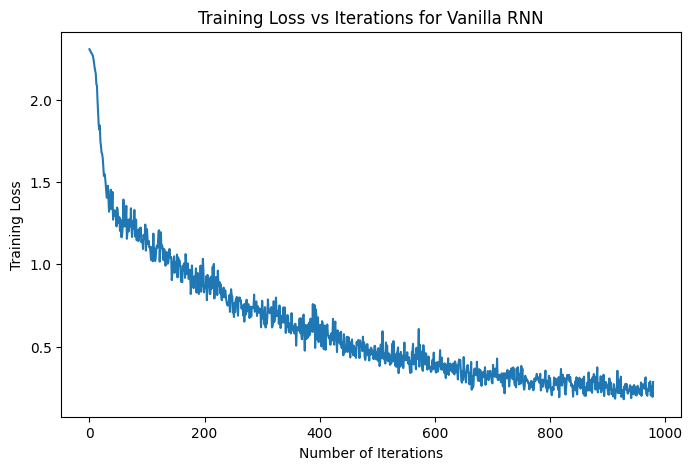

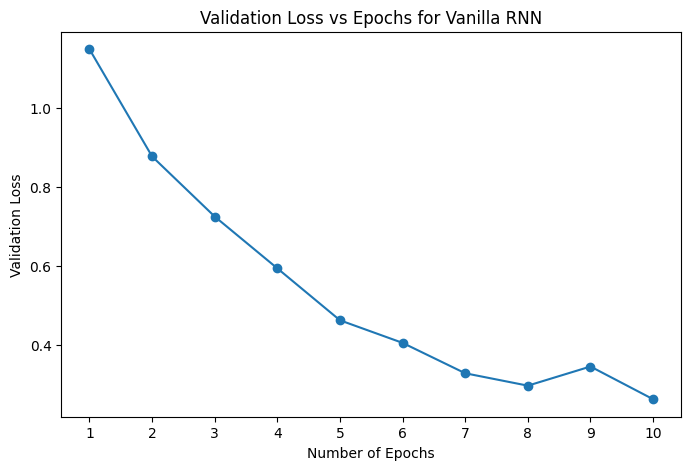

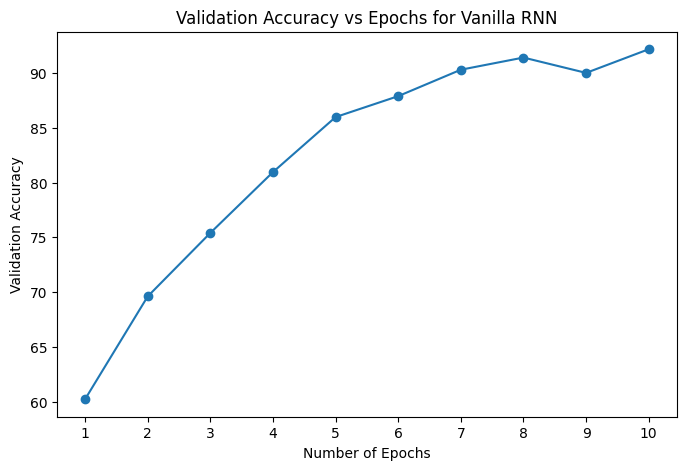

In [ ]:
plotter(train_loss, val_loss, val_accuracy, "Vanilla RNN")

In [ ]:
evaluate_model(model1, dataloaders['test'], device=device)

Accuracy on test set: 92.40%


Given the simplicity of the above Net we've reached quite a good result. I then tried to keep the same net and changing some value as for example:
- learning rate (not better results)
- activation function ReLu (not better results)
- add more neurons in the hidden layer (not better results)

In [ ]:
# Hyperparameters
learning_rate = 3e-4 # karpathy's constant
epochs = 10

In [ ]:
criterion_test1 = nn.CrossEntropyLoss() # already implement softmax()
model_test1 = myRNN(hidden_size=256, activation='relu').to(device)
optimizer_test1 = torch.optim.Adam(model_test1.parameters(), lr=learning_rate)

In [ ]:
train_loss_test1, val_loss_test1, val_accuracy_test1 = train_model(model_test1, dataloaders['train'], criterion_test1, optimizer_test1, epochs, device=device)

Epoch [1/10] - Validation loss: 1.2059, Validation accuracy: 58.44%
Epoch [2/10] - Validation loss: 0.9451, Validation accuracy: 68.04%
Epoch [3/10] - Validation loss: 0.6480, Validation accuracy: 78.24%
Epoch [4/10] - Validation loss: 0.5506, Validation accuracy: 82.77%
Epoch [5/10] - Validation loss: 0.4303, Validation accuracy: 87.05%
Epoch [6/10] - Validation loss: 0.3766, Validation accuracy: 88.28%
Epoch [7/10] - Validation loss: 0.3120, Validation accuracy: 90.53%
Epoch [8/10] - Validation loss: 0.2634, Validation accuracy: 92.33%
Epoch [9/10] - Validation loss: 0.2633, Validation accuracy: 92.12%
Epoch [10/10] - Validation loss: 0.2361, Validation accuracy: 93.03%


In [ ]:
evaluate_model(model_test1, dataloaders['test'], device=device)

Accuracy on test set: 93.25%


The Net didn't provide a better performance, so let's try to change the Net a little.

PS: I didn't plot the loss functions since the results were not better.

In [ ]:
class myRNN_test2(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10, activation='tanh'): # each input vector to the RNN represents a single row of pixels
    super(myRNN_test2, self).__init__()
    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, nonlinearity=activation, device=device) # start with a network with hidden state size of 128
    self.layer2 = nn.Linear(hidden_size, 64) ### ADD A LAYER IN THE FULLY CONNECTED NET
    self.layer3 = nn.Linear(64, output_size)  # Output layer
    self.batch_norm = nn.BatchNorm1d(hidden_size)
    self.device = device
    self.hidden_size = hidden_size

  def forward(self, X):
    X = X.permute(1, 0, 2).to(self.device)
    # Initialize the hidden layer
    hiddenlayer = torch.zeros(1, X.size(1), self.hidden_size, device=self.device)
    _, hiddenlayer = self.rnn(X, hiddenlayer) # return output, h_t
    out1 = self.batch_norm(hiddenlayer.squeeze(0)) ### ADD NORMALIZATION LAYER
    out1 = self.layer2(out1) # let the output activation be linear
    out2 = self.layer3(out1)
    return out2.reshape(-1, 10)

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

criterion_test2 = nn.CrossEntropyLoss() # already implement softmax()
model_test2 = myRNN_test2(hidden_size=128, activation='tanh').to(device)
optimizer_test2 = torch.optim.Adam(model_test2.parameters(), lr=learning_rate)

train_loss_test2, val_loss_test2, val_accuracy_test2 = train_model(model_test2, dataloaders['train'], criterion_test2, optimizer_test2, epochs, device=device)

evaluate_model(model_test2, dataloaders['test'], device=device)

Epoch [1/10] - Validation loss: 0.6979, Validation accuracy: 79.11%
Epoch [2/10] - Validation loss: 0.3735, Validation accuracy: 88.85%
Epoch [3/10] - Validation loss: 0.2921, Validation accuracy: 90.97%
Epoch [4/10] - Validation loss: 0.2491, Validation accuracy: 92.18%
Epoch [5/10] - Validation loss: 0.1936, Validation accuracy: 94.15%
Epoch [6/10] - Validation loss: 0.1864, Validation accuracy: 94.55%
Epoch [7/10] - Validation loss: 0.1553, Validation accuracy: 95.56%
Epoch [8/10] - Validation loss: 0.1688, Validation accuracy: 94.94%
Epoch [9/10] - Validation loss: 0.1402, Validation accuracy: 95.71%
Epoch [10/10] - Validation loss: 0.1327, Validation accuracy: 96.3%
Accuracy on test set: 96.53%


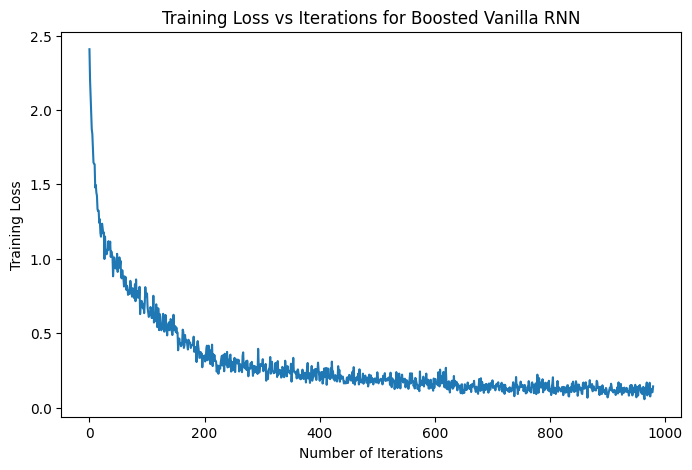

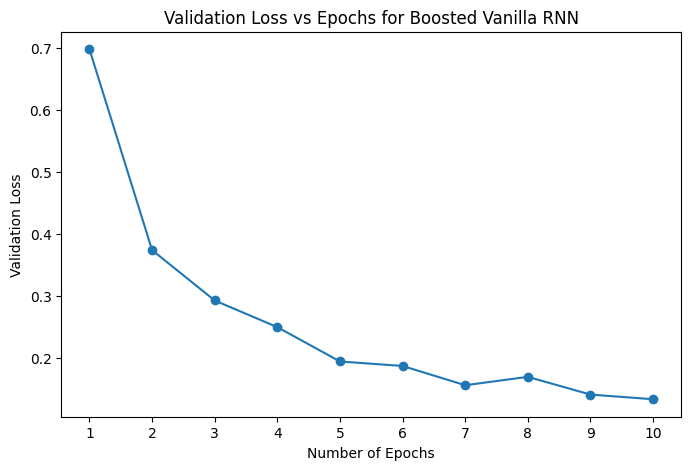

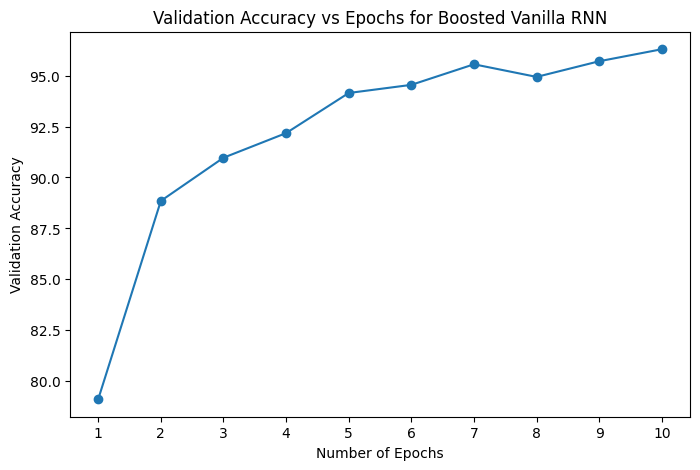

In [ ]:
plotter(train_loss_test2, val_loss_test2, val_accuracy_test2, "Boosted Vanilla RNN")

Above I added a batch normalization layer to the outputs of the RNN before passing them through the fully connected layers. This helps to stabilize the training process and improve convergence by reducing the internal covariate shift. Remember that RNN has also the problem of vanishing/exploding GD. This definitely helps on avoiding the exploding gradient.
</br>
Moreover, I added another layer on the fully connected layer so to have a more complex net after the RNN output.
</br>
Accuracy has increased. Interesting to see that the converge is much faster (see plot below).

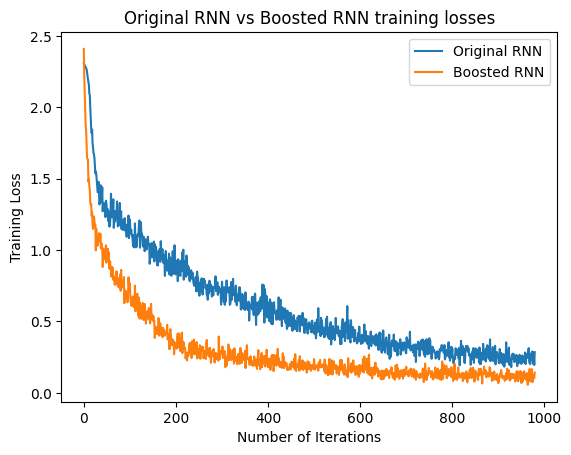

In [ ]:
plt.plot(train_loss, label="Original RNN")
plt.plot(train_loss_test2, label="Boosted RNN")
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.title('Original RNN vs Boosted RNN training losses')
plt.legend()
plt.show()

# 1 MNIST classification using LSTM


In [21]:
class LSTM(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, device=device)
    self.layer2 = nn.Linear(hidden_size, output_size)
    self.device = device
    self.hidden_size = hidden_size

  def forward(self, X):
    # Initialize hidden and cell states to zero
    hiddenstate = torch.zeros(1,X.size(0),self.hidden_size, device=self.device)
    cellstate = torch.zeros(1,X.size(0),self.hidden_size, device=self.device)
    # Adjust input dimensions and move to the correct device
    X = X.permute(1, 0, 2).to(self.device)
    # Pass input through LSTM layer
    out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate)) # out: learned representation of the entire input image
    # Apply linear layer to the output
    out = self.layer2(out[27])
    return out.reshape(-1, 10)

In [22]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

criterion2 = nn.CrossEntropyLoss() # already implement softmax()
model2 = LSTM(hidden_size=128).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

train_loss2, val_loss2, val_accuracy2 = train_model(model2, dataloaders['train'], criterion2, optimizer2, epochs, device=device)

evaluate_model(model2, dataloaders['test'], device=device)

Epoch [1/10] - Validation loss: 0.5987, Validation accuracy: 80.75%
Epoch [2/10] - Validation loss: 0.2674, Validation accuracy: 92.26%
Epoch [3/10] - Validation loss: 0.2090, Validation accuracy: 93.76%
Epoch [4/10] - Validation loss: 0.1453, Validation accuracy: 95.62%
Epoch [5/10] - Validation loss: 0.1289, Validation accuracy: 96.21%
Epoch [6/10] - Validation loss: 0.1026, Validation accuracy: 96.92%
Epoch [7/10] - Validation loss: 0.1150, Validation accuracy: 96.43%
Epoch [8/10] - Validation loss: 0.1031, Validation accuracy: 96.77%
Epoch [9/10] - Validation loss: 0.0920, Validation accuracy: 97.01%
Epoch [10/10] - Validation loss: 0.0818, Validation accuracy: 97.46%
Accuracy on test set: 97.28%


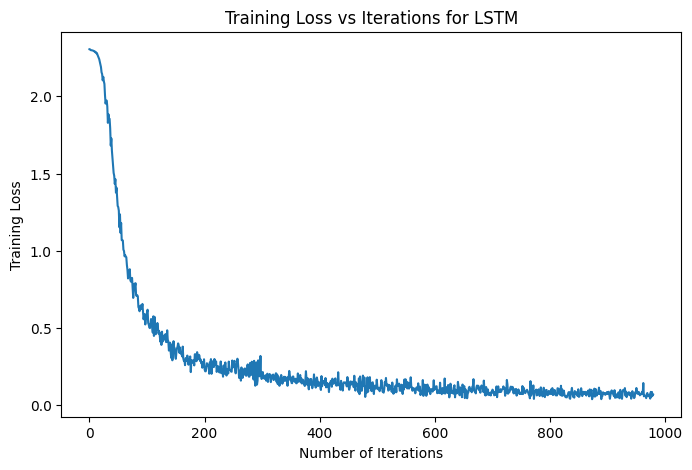

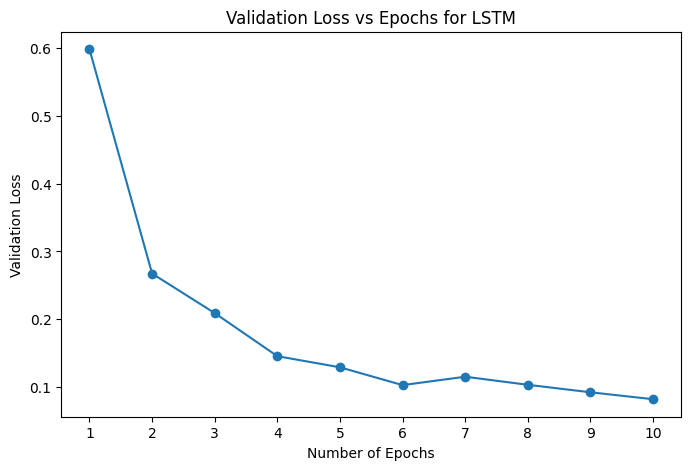

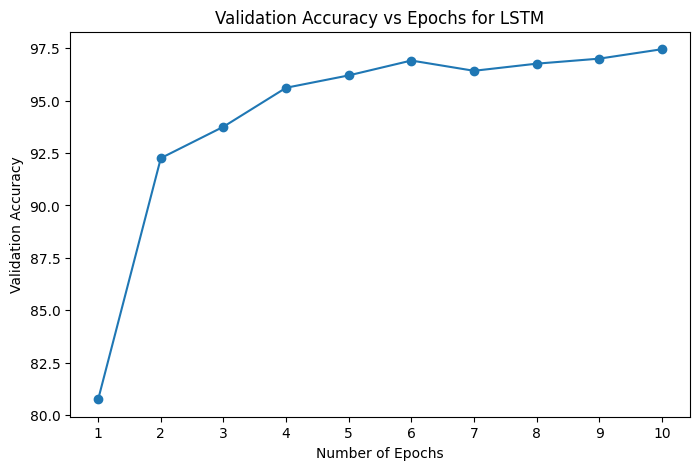

In [23]:
plotter(train_loss2, val_loss2, val_accuracy2, "LSTM")

The model already performs quite well. Therefore I only try to add a fully connected layer. I avoided to add the batch normalization because I would have add too much complexity on the model for a poor performance improvement (the ouput of the LSTM needs to be reshape and then reshape back).

In [19]:
class LSTM_test1(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10):
    super(LSTM_test1, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, device=device)
    self.layer2 = nn.Linear(hidden_size, int(hidden_size / 2)) ### ADD A LAYER IN THE FULLY CONNECTED NET
    self.layer3 = nn.Linear(int(hidden_size / 2), output_size)  # Output layer
    self.batch_norm = nn.BatchNorm1d(hidden_size)
    self.device = device
    self.hidden_size = hidden_size

  def forward(self, X):
    # Initialize hidden and cell states to zero
    hiddenstate = torch.zeros(1,X.size(0),self.hidden_size, device=self.device)
    cellstate = torch.zeros(1,X.size(0),self.hidden_size, device=self.device)
    # Adjust input dimensions and move to the correct device
    X = X.permute(1, 0, 2).to(self.device)
    # Pass input through LSTM layer
    out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate)) # out: contains the hidden states for each time step in the sequence
    # Apply linear layer to the output
    # print(out[27].shape)
    out1 = self.layer2(self.batch_norm(out[27])) ### ADD NORMALIZATION LAYER
    out2 = self.layer3(out1)
    return out2.reshape(-1, 10)

In [20]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

criterion2_test1 = nn.CrossEntropyLoss() # already implement softmax()
model2_test1 = LSTM_test1().to(device)
optimizer2_test1 = torch.optim.Adam(model2_test1.parameters(), lr=learning_rate)

train_loss2_test1, val_loss2_test1, val_accuracy2_test1 = train_model(model2_test1, dataloaders['train'], criterion2_test1, optimizer2_test1, epochs, device=device)

evaluate_model(model2_test1, dataloaders['test'], device=device)

Epoch [1/10] - Validation loss: 0.3263, Validation accuracy: 89.41%
Epoch [2/10] - Validation loss: 0.1771, Validation accuracy: 94.31%
Epoch [3/10] - Validation loss: 0.1245, Validation accuracy: 96.08%
Epoch [4/10] - Validation loss: 0.1023, Validation accuracy: 96.62%
Epoch [5/10] - Validation loss: 0.0835, Validation accuracy: 97.22%
Epoch [6/10] - Validation loss: 0.0719, Validation accuracy: 97.63%
Epoch [7/10] - Validation loss: 0.0674, Validation accuracy: 97.81%
Epoch [8/10] - Validation loss: 0.0565, Validation accuracy: 98.16%
Epoch [9/10] - Validation loss: 0.0542, Validation accuracy: 98.24%
Epoch [10/10] - Validation loss: 0.0523, Validation accuracy: 98.37%
Accuracy on test set: 98.14%


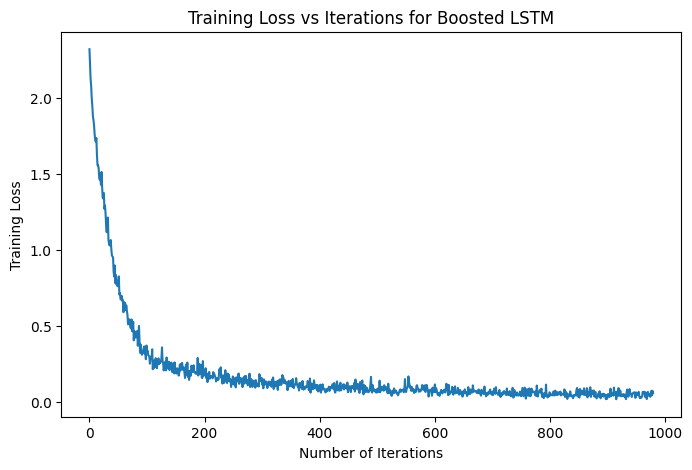

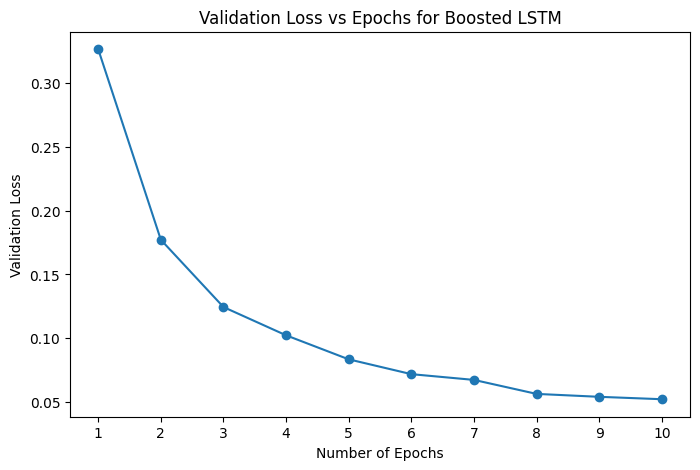

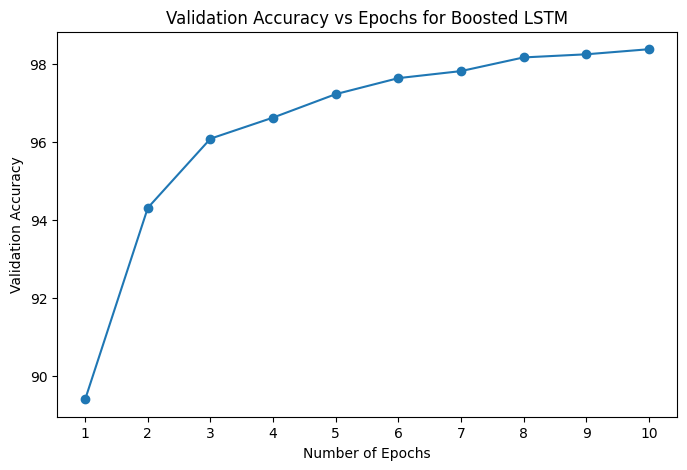

In [24]:
plotter(train_loss2_test1, val_loss2_test1, val_accuracy2_test1, "Boosted LSTM")

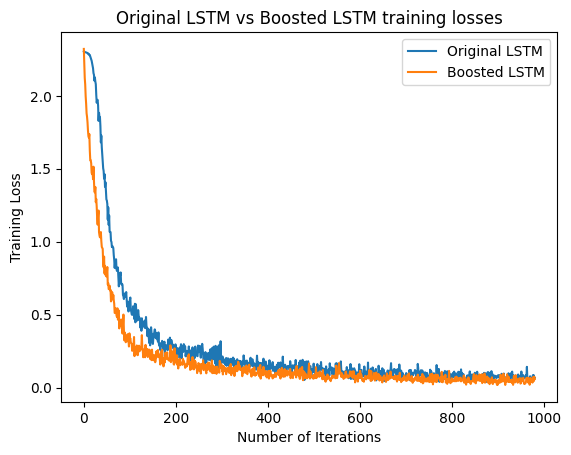

In [25]:
plt.plot(train_loss2, label="Original LSTM")
plt.plot(train_loss2_test1, label="Boosted LSTM")
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.title('Original LSTM vs Boosted LSTM training losses')
plt.legend()
plt.show()

At first I added just a FC layer and the performance where basically the same. I therefore applied a batch normalization before feeding to thte FC layer and the accuracy has imporoved a bit. The interesting thing it's also that the Net now learn faster then the first LSTM! This is quite nice.

# 1 MNIST classification using RNN bidirectional

In [30]:
class Bi_RNN(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10, num_layers=1):
    super(Bi_RNN, self).__init__()
    self.rnn = nn.RNN(input_size,hidden_size,num_layers,bidirectional=True) # Add bidirectional here
    self.layer2 = nn.Linear(hidden_size*2, output_size)
    self.device = device
    self.hidden_size = hidden_size

  def forward(self, X):
    X = X.permute(1, 0, 2).to(self.device)
    hiddenlayer = torch.zeros(2, X.size(1), self.hidden_size, device=self.device)
    _,hiddenlayer = self.rnn(X, hiddenlayer)
    finp, binp = hiddenlayer[0],hiddenlayer[1]
    inp = torch.cat((finp,binp),dim=-1)
    out = self.layer2(inp)
    return out

In [31]:
learning_rate = 0.001
epochs = 10

In [32]:
criterion3 = nn.CrossEntropyLoss() # already implement softmax()
model3 = Bi_RNN().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [33]:
train_loss3, val_loss3, val_accuracy3 = train_model(model3, dataloaders['train'], criterion3, optimizer3, epochs, device=device)

Epoch [1/10] - Validation loss: 0.6752, Validation accuracy: 79.2%
Epoch [2/10] - Validation loss: 0.3619, Validation accuracy: 89.06%
Epoch [3/10] - Validation loss: 0.2622, Validation accuracy: 91.86%
Epoch [4/10] - Validation loss: 0.1990, Validation accuracy: 93.97%
Epoch [5/10] - Validation loss: 0.1705, Validation accuracy: 94.96%
Epoch [6/10] - Validation loss: 0.1747, Validation accuracy: 94.52%
Epoch [7/10] - Validation loss: 0.1580, Validation accuracy: 95.09%
Epoch [8/10] - Validation loss: 0.1383, Validation accuracy: 95.84%
Epoch [9/10] - Validation loss: 0.1324, Validation accuracy: 95.91%
Epoch [10/10] - Validation loss: 0.1221, Validation accuracy: 96.4%


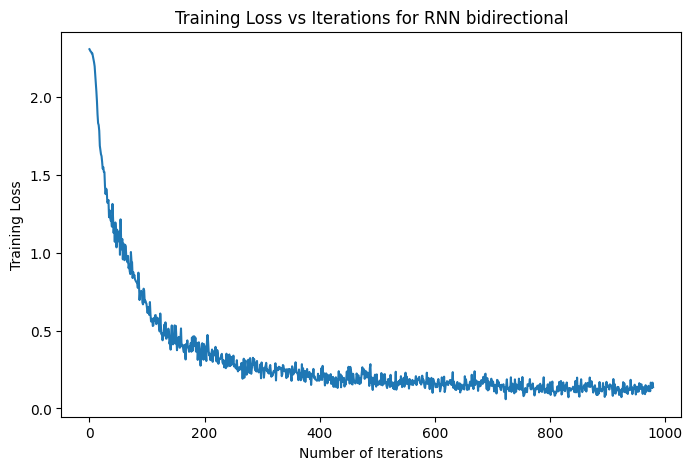

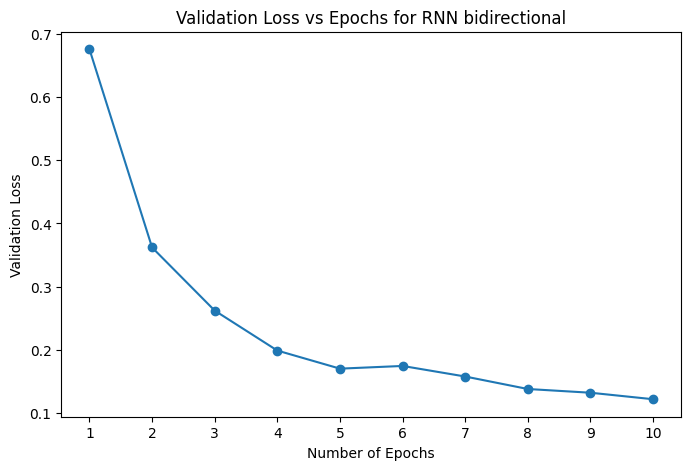

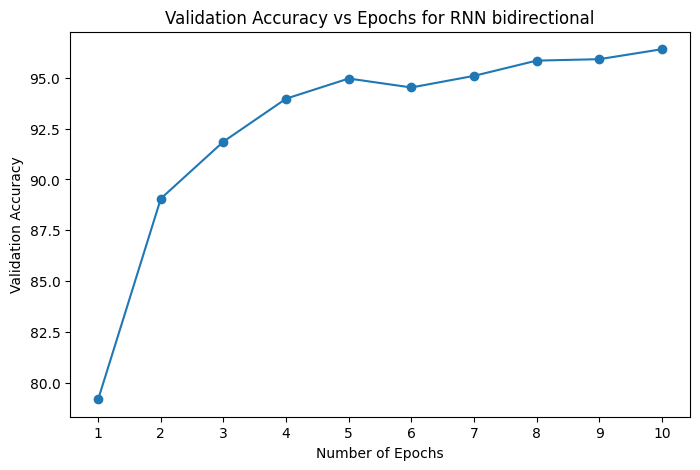

In [34]:
plotter(train_loss3, val_loss3, val_accuracy3, "RNN bidirectional")

In [35]:
evaluate_model(model3, dataloaders['test'], device=device)

Accuracy on test set: 96.40%


As first experiment on the above Net we could switch from RNN to LSTM (bidirectional).

In [36]:
class Bi_RNN_test1(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10, num_layers=1):
    super(Bi_RNN_test1, self).__init__()
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,bidirectional=True) ## USE LSTM CELL
    self.layer2 = nn.Linear(hidden_size*2, output_size)
    self.device = device
    self.hidden_size = hidden_size

  def forward(self, X):
    X = X.permute(1, 0, 2).to(self.device)
    hiddenlayer = (torch.zeros(2, X.size(1), self.hidden_size, device=self.device)
                  , torch.zeros(2, X.size(1), self.hidden_size, device=self.device))

    lstm_out, _ = self.lstm(X, hiddenlayer)
    lstm_out = lstm_out[-1]
    out = self.layer2(lstm_out)
    return out

In [37]:
criterion3_test1 = nn.CrossEntropyLoss() # already implement softmax()
model3_test1 = Bi_RNN_test1().to(device)
optimizer3_test1 = torch.optim.Adam(model3_test1.parameters(), lr=learning_rate)
train_loss3_test1, val_loss3_test1, val_accuracy3_test1 = train_model(model3_test1, dataloaders['train'], criterion3_test1, optimizer3_test1, epochs, device=device)

evaluate_model(model3_test1, dataloaders['test'], device=device)

Epoch [1/10] - Validation loss: 0.5973, Validation accuracy: 82.45%
Epoch [2/10] - Validation loss: 0.3229, Validation accuracy: 90.1%
Epoch [3/10] - Validation loss: 0.2258, Validation accuracy: 93.45%
Epoch [4/10] - Validation loss: 0.1936, Validation accuracy: 94.11%
Epoch [5/10] - Validation loss: 0.1519, Validation accuracy: 95.52%
Epoch [6/10] - Validation loss: 0.1235, Validation accuracy: 96.29%
Epoch [7/10] - Validation loss: 0.1201, Validation accuracy: 96.42%
Epoch [8/10] - Validation loss: 0.1024, Validation accuracy: 96.95%
Epoch [9/10] - Validation loss: 0.0963, Validation accuracy: 97.06%
Epoch [10/10] - Validation loss: 0.0833, Validation accuracy: 97.53%
Accuracy on test set: 97.31%


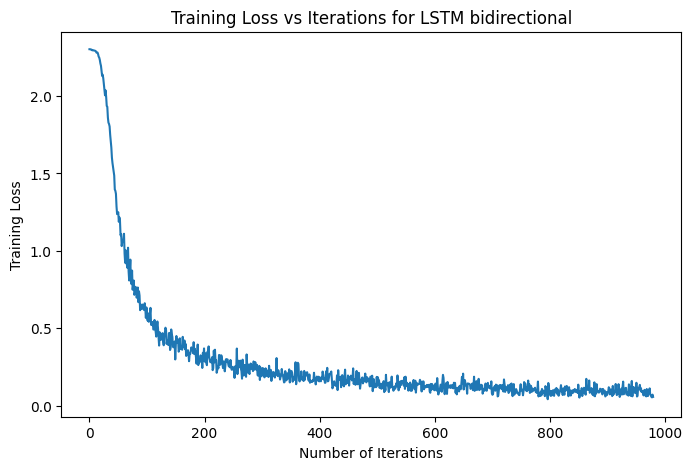

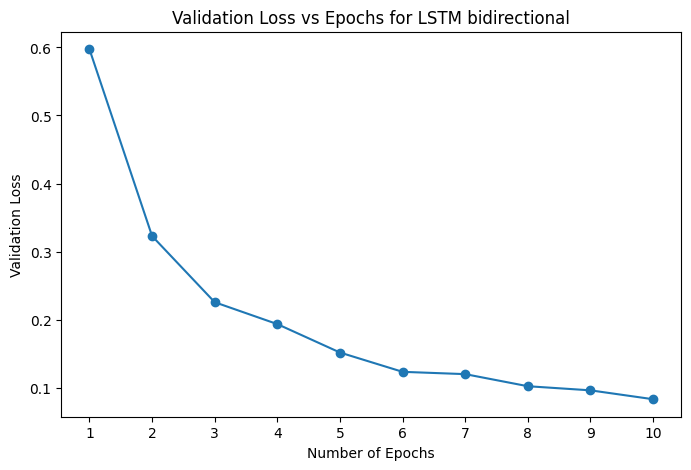

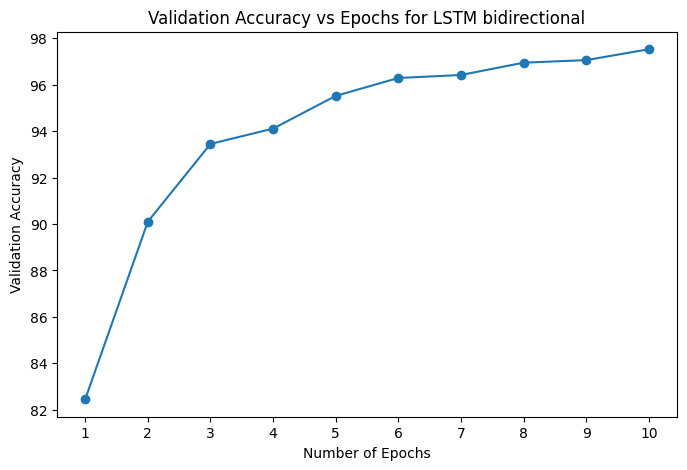

In [38]:
plotter(train_loss3_test1, val_loss3_test1, val_accuracy3_test1, "LSTM bidirectional")

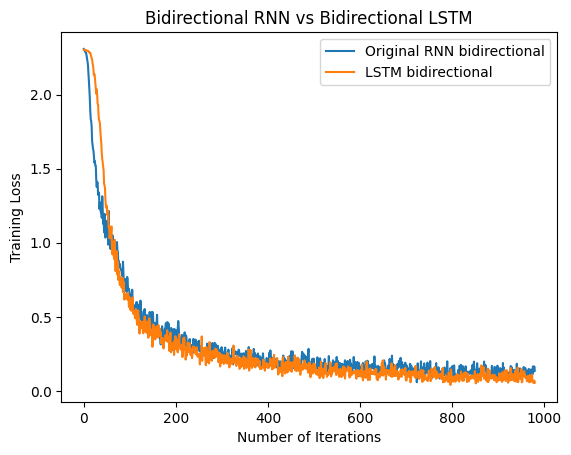

In [39]:
plt.plot(train_loss3, label="Original RNN bidirectional")
plt.plot(train_loss3_test1, label="LSTM bidirectional")
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.title('Bidirectional RNN vs Bidirectional LSTM')
plt.legend()
plt.show()

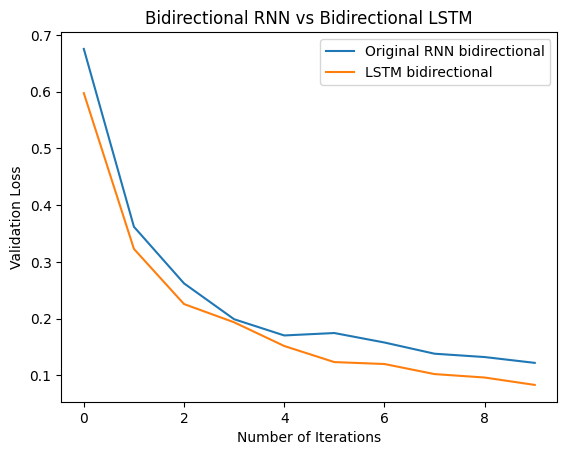

In [40]:
plt.plot(val_loss3, label="Original RNN bidirectional")
plt.plot(val_loss3_test1, label="LSTM bidirectional")
plt.xlabel('Number of Iterations')
plt.ylabel('Validation Loss')
plt.title('Bidirectional RNN vs Bidirectional LSTM')
plt.legend()
plt.show()

Bidirectional LSTM seems to work a bit better, at least the training loss is lower therefore it reduces the bias (but with different trainings I saw different results, so it might be due to randomness!!). But also the validation loss has improved, therefore LSTM bidirectional is acting quite nicely!

In [26]:
class Bi_RNN_test2(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10, num_layers=1):
    super(Bi_RNN_test2, self).__init__()
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,bidirectional=True)
    self.layer_norm = nn.LayerNorm(hidden_size * 2) ### ADD NORMALIZATION
    self.layer2 = nn.Linear(hidden_size*2, int(hidden_size / 2))
    self.layer3 = nn.Linear(int(hidden_size / 2), output_size) ### ADD ANOTHER FC LAYER
    self.device = device
    self.hidden_size = hidden_size

  def forward(self, X):
    X = X.permute(1, 0, 2).to(self.device)
    hiddenlayer = (torch.zeros(2, X.size(1), self.hidden_size, device=self.device)
                  , torch.zeros(2, X.size(1), self.hidden_size, device=self.device))

    lstm_out, _ = self.lstm(X, hiddenlayer)
    out1 = self.layer2(self.layer_norm(lstm_out[-1]))
    out2 = self.layer3(out1)
    return out2

In [27]:
criterion3_test2 = nn.CrossEntropyLoss() # already implement softmax()
model3_test2 = Bi_RNN_test2().to(device)
optimizer3_test2 = torch.optim.Adam(model3_test2.parameters(), lr=learning_rate)
train_loss3_test2, val_loss3_test2, val_accuracy3_test2 = train_model(model3_test2, dataloaders['train'], criterion3_test2, optimizer3_test2, epochs, device=device)

evaluate_model(model3_test2, dataloaders['test'], device=device)

Epoch [1/10] - Validation loss: 0.4893, Validation accuracy: 84.18%
Epoch [2/10] - Validation loss: 0.2397, Validation accuracy: 92.67%
Epoch [3/10] - Validation loss: 0.1807, Validation accuracy: 94.46%
Epoch [4/10] - Validation loss: 0.1478, Validation accuracy: 95.32%
Epoch [5/10] - Validation loss: 0.1145, Validation accuracy: 96.27%
Epoch [6/10] - Validation loss: 0.0908, Validation accuracy: 97.15%
Epoch [7/10] - Validation loss: 0.0815, Validation accuracy: 97.37%
Epoch [8/10] - Validation loss: 0.0749, Validation accuracy: 97.63%
Epoch [9/10] - Validation loss: 0.0766, Validation accuracy: 97.6%
Epoch [10/10] - Validation loss: 0.0606, Validation accuracy: 98.03%
Accuracy on test set: 98.04%


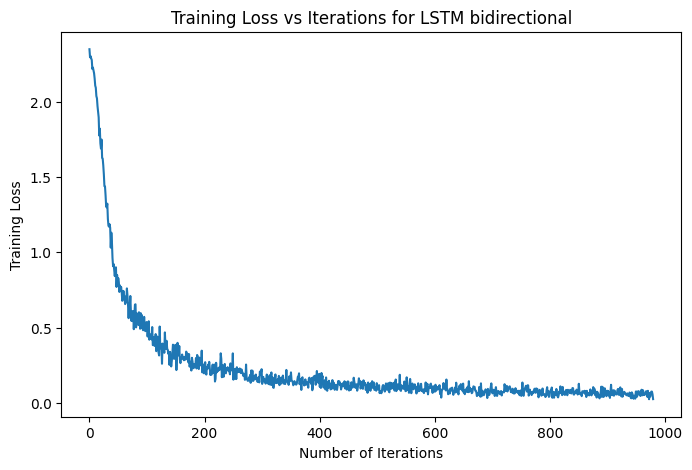

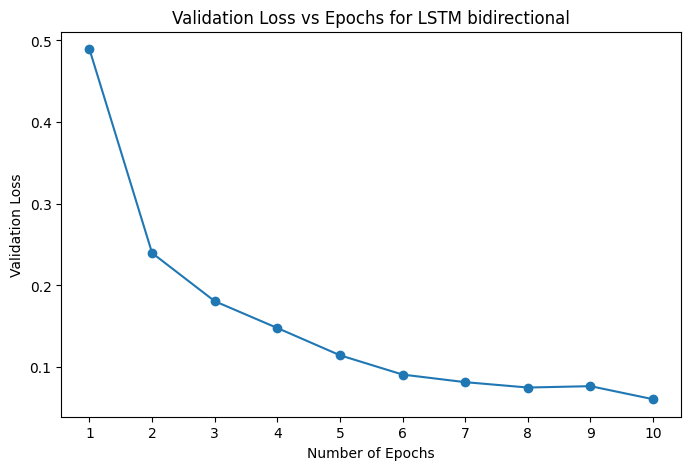

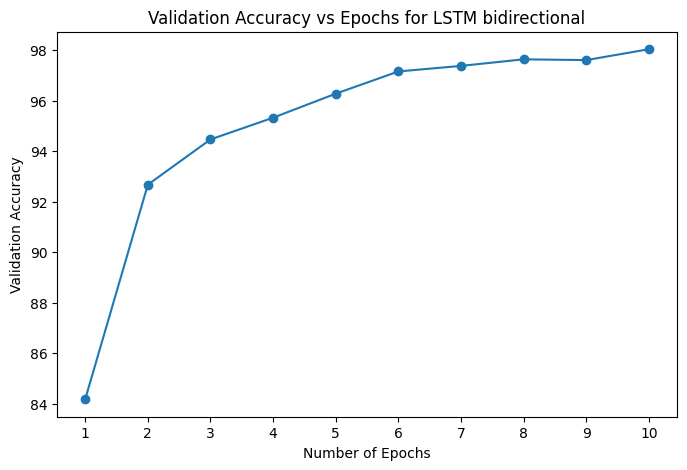

In [28]:
plotter(train_loss3_test2, val_loss3_test2, val_accuracy3_test2, "LSTM bidirectional")

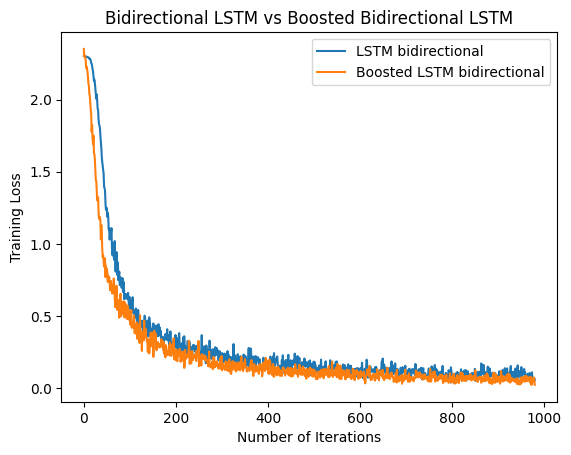

In [41]:
plt.plot(train_loss3, label="LSTM bidirectional")
plt.plot(train_loss3_test1, label="LSTM bidirectional")
plt.plot(train_loss3_test2, label="Boosted LSTM bidirectional")
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.title('Bidirectional LSTM vs Boosted Bidirectional LSTM')
plt.legend()
plt.show()

The performance is the same. We have decrease the loss function, ie the Net has less bias, but the variance is the same, therefore it seems we overfit the model. I'm gonna try to add just the normalization (so using just one FC layer).

In [43]:
class Bi_RNN_test3(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10, num_layers=1):
    super(Bi_RNN_test3, self).__init__()
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,bidirectional=True)
    self.layer_norm = nn.LayerNorm(hidden_size * 2) ### ADD NORMALIZATION
    self.layer2 = nn.Linear(hidden_size*2, output_size)
    self.device = device
    self.hidden_size = hidden_size

  def forward(self, X):
    X = X.permute(1, 0, 2).to(self.device)
    hiddenlayer = (torch.zeros(2, X.size(1), self.hidden_size, device=self.device)
                  , torch.zeros(2, X.size(1), self.hidden_size, device=self.device))

    lstm_out, _ = self.lstm(X, hiddenlayer)
    lstm_out = self.layer_norm(lstm_out[-1])
    out = self.layer2(lstm_out)
    return out

In [44]:
criterion3_test3 = nn.CrossEntropyLoss() # already implement softmax()
model3_test3 = Bi_RNN_test3().to(device)
optimizer3_test3 = torch.optim.Adam(model3_test3.parameters(), lr=learning_rate)
train_loss3_test3, val_loss3_test3, val_accuracy3_test3 = train_model(model3_test3, dataloaders['train'], criterion3_test3, optimizer3_test3, epochs, device=device)

evaluate_model(model3_test3, dataloaders['test'], device=device)

Epoch [1/10] - Validation loss: 0.4495, Validation accuracy: 86.45%
Epoch [2/10] - Validation loss: 0.1949, Validation accuracy: 94.16%
Epoch [3/10] - Validation loss: 0.1385, Validation accuracy: 95.91%
Epoch [4/10] - Validation loss: 0.0999, Validation accuracy: 96.97%
Epoch [5/10] - Validation loss: 0.1016, Validation accuracy: 96.85%
Epoch [6/10] - Validation loss: 0.0912, Validation accuracy: 97.1%
Epoch [7/10] - Validation loss: 0.0690, Validation accuracy: 97.89%
Epoch [8/10] - Validation loss: 0.0671, Validation accuracy: 97.84%
Epoch [9/10] - Validation loss: 0.0631, Validation accuracy: 98.21%
Epoch [10/10] - Validation loss: 0.0723, Validation accuracy: 97.82%
Accuracy on test set: 97.66%


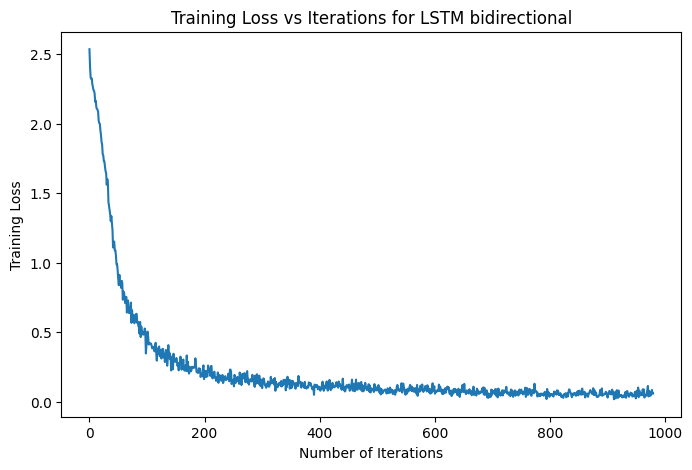

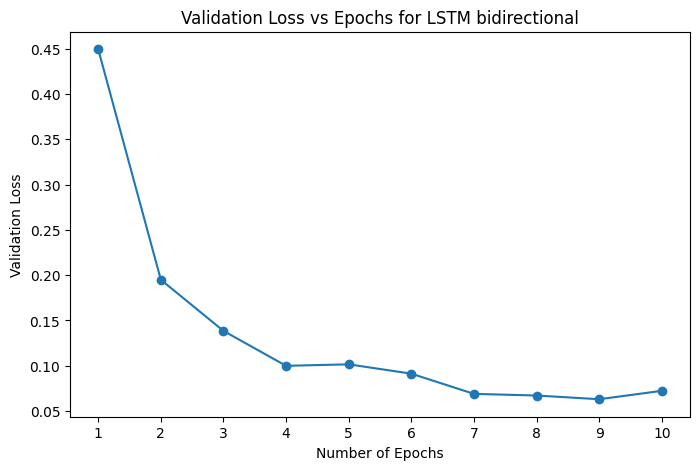

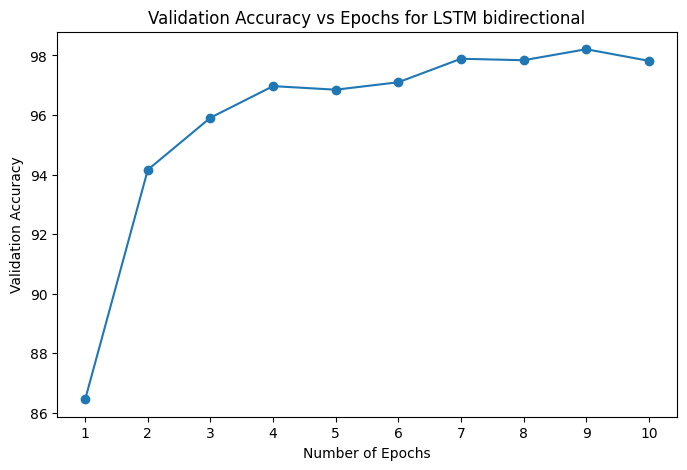

In [45]:
plotter(train_loss3_test3, val_loss3_test3, val_accuracy3_test3, "LSTM bidirectional")

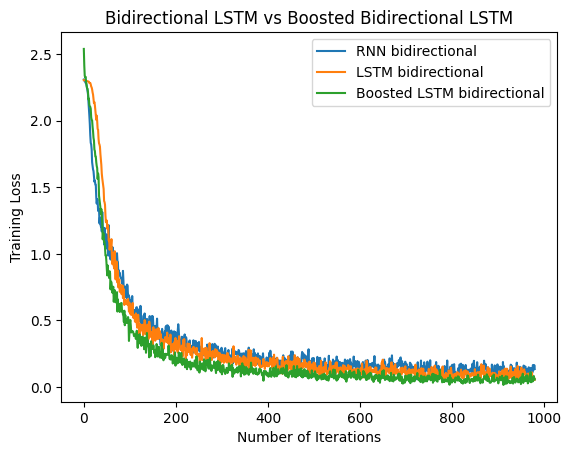

In [46]:
plt.plot(train_loss3, label="RNN bidirectional")
plt.plot(train_loss3_test1, label="LSTM bidirectional")
plt.plot(train_loss3_test3, label="Boosted LSTM bidirectional")
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.title('Bidirectional LSTM vs Boosted Bidirectional LSTM')
plt.legend()
plt.show()

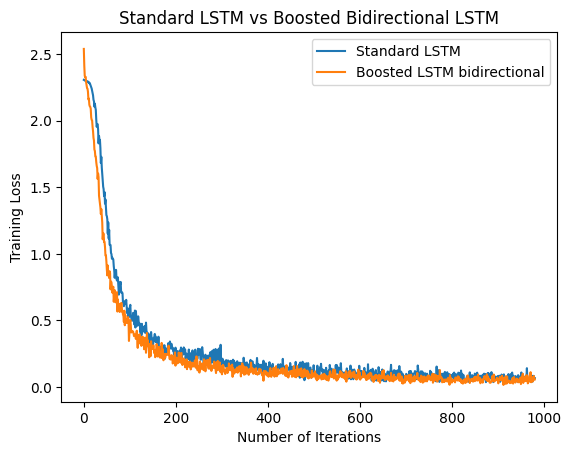

In [47]:
plt.plot(train_loss2, label="Standard LSTM")
plt.plot(train_loss3_test3, label="Boosted LSTM bidirectional")
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.title('Standard LSTM vs Boosted Bidirectional LSTM')
plt.legend()
plt.show()

The loss function is as low as in the test above, but the performance on the unseen data has improved! </br>
What I want to add, though, is that the performance was already very good with the standard LSTM. And by using a bidirectional RNN (or LSTM) we could risk to overfit the model without not much earning on the accuracy. The image has in fact some dependency on the "future" rows of pixels but each pixel or row does not depend on information from future or past pixels in the way that a time series or language data might (and here we are using very simple images!). So NB: each row of pixels is treated as a "time step". However, this dependency is artificial. The network doesn't truly benefit from reverse-order processing. </br>
Therefore using more parameters and increasing the complexity of the model is not worth it.

--------------------------------------------------------------
Provide sample inputs from the test data and predictions made by your best model - check
with at least 10 custom input images from your own handwriting and predictions made by your best model. Make sure to pre-process the custom input format of the image. It should be same as the format of MNIST data input (28x28 resolution). </br>
Please comment on your observations of the above predictions on custom inputs. </br>

For the above reasons I adopt the LSTM() model!

In [48]:
# Best performance given by
print(model2)

LSTM(
  (lstm): LSTM(28, 128)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

folder_path = '/content/drive/MyDrive/CUSTOM_PICS'


def load_custom_images(folder_path):
    # Updated transformation for MNIST matching
    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((28, 28)),  # Resize to 28x28
        transforms.ToTensor(),  # Convert to tensor
        transforms.Lambda(lambda x: 1 - x)  # Invert so background becomes 0, digit becomes 1
    ])

    images = []
    for i in range(10):  # Iterate through images 0-9
        img_path = os.path.join(folder_path, f"my{i}.png")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            img = transform(img)
            images.append(img)
        else:
            print(f"Image {img_path} not found.")

    # Stack all images into a single tensor
    images_tensor = torch.stack(images)
    return images_tensor

In [51]:
custom_images = load_custom_images(folder_path)

In [52]:
# Reshape to [N, 28, 28]
# Squeeze to remove the channel dimension, if necessary
print(custom_images.shape)
custom_images_t = custom_images.squeeze(1)  # Shape: [N, 28, 28]

# Now reshape it to [N, 28, 28] for the LSTM, where 28 is the sequence length
# Here, we are treating each row as a sequence step
custom_images_t = custom_images_t.view(custom_images_t.size(0), 28, 28)  # Shape: [N, 28, 28]
print(custom_images_t.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10, 28, 28])


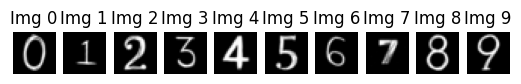

In [53]:
# Visualize the custom images after transformation
for i in range(len(custom_images_t)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(custom_images_t[i].cpu().detach().numpy(), cmap='gray')
    plt.title(f'Img {i}')
    plt.axis('off')
plt.show()

In [54]:
# Set the model to evaluation mode and move custom_images_t to device
model2.eval()
custom_images_t = custom_images_t.to(device)

with torch.no_grad():  # Disable gradient calculation
    outputs = model2(custom_images_t)  # Ensure correct shape
    _, predicted = torch.max(outputs.data, 1)  # Get predictions

print(predicted)

labels=[0,1,2,3,4,5,6,7,8,9]

tensor([0, 2, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


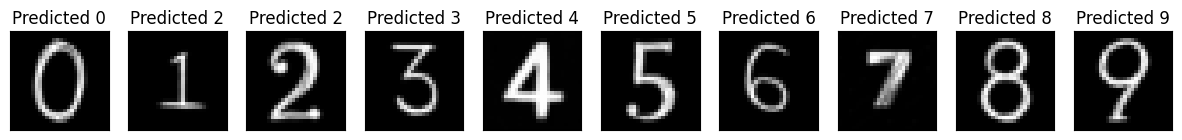

Predictions: [0, 2, 2, 3, 4, 5, 6, 7, 8, 9]
Real labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [55]:
fig, ax = plt.subplots(1, 10, figsize=(15, 5))

for i in labels:
    ax[i].imshow(custom_images_t[i].cpu().detach().numpy(), cmap='gray')  # Use custom_images_t[i]
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f'Predicted {predicted[i].item()}')  # Convert tensor to scalar for title

plt.show()

print('Predictions:', predicted.cpu().numpy().tolist())  # Convert to list for easier printing
print('Real labels:', labels)

# 2 Adding two binary strings
## 2.1 Data preparation
To train the model, we need a batch size of two binary strings of a given length L (say 5) and the corresponding output as training data. Be cautious that the output string can have one extra bit and make sure you pad your input strings with 0's appropriately. You can either generate the whole dataset beforehand and store it in a file or you can generate it on the go
during training.

In [56]:
np.flip(np.array([1,1,1,0,0]))

array([0, 0, 1, 1, 1])

In [57]:
def bin_generator(L):
  """
  Generate pairs of binary strings and their summed output.
  :param:
  L: max length for the binary representation.

  :return:
  Return a tuple containing the concatenated input binary representation as columnms.
  Concatenated with binary representation of the sum.
  """
  # Generate random int for binary strings
  # Each string has up to L bits
  N1 = np.random.randint(0,2**(L-1))
  N2 = np.random.randint(0,2**(L-1))
  # Compute the sum of the two integers
  S = N1+N2

  # Here I initialize the arrays that will hold the binary representations
  B1 = np.zeros((1,L)) # N1
  B2 = np.zeros((1,L)) # N2
  B3 = np.zeros((L)) # S

  # Convert N1 and N2 and S to binary
  # NB: I'm flipping to get the LSB to left side
  b = np.flip(np.array(list(np.binary_repr(N1)), dtype=int))
  B1[0][0:len(b)] = b[0:]
  b = np.flip(np.array(list(np.binary_repr(N2)), dtype=int))
  B2[0][0:len(b)] = b[0:]
  b = np.flip(np.array(list(np.binary_repr(S)), dtype=int))
  B3[0:len(b)] = b[0:]

  return(np.concatenate((np.transpose(B1),np.transpose(B2)),axis=1),B3)

In [58]:
def generate_datasets(L=5):
  """
  Generate the datasets needed for training, validation and testing.
  NB: the length of binary representation in the test dataset is random!
  :param:
  L: max length for the binary representation.

  :return:
  datasets X and datasets Y.
  """
  train_X = []
  train_Y = []
  # For training, you need to generate separate datasets for training
  # with fixed-length strings
  for i in range(250):
    a,b = bin_generator(L)
    train_X.append(a)
    train_Y.append(b)

  val_X = []
  val_Y = []
  for i in range(100):
    a,b = bin_generator(L)
    val_X.append(a)
    val_Y.append(b)

  test_X = []
  test_Y = []
  for i in range(100):
    # For testing, you should use datasets that include strings of different lengths (1 to 20)
    # to observe generalization ability
    L = np.random.randint(1,21)
    a,b = bin_generator(L)
    test_X.append(a)
    test_Y.append(b)

  return train_X, train_Y, val_X, val_Y, test_X, test_Y

NB: first I have the LSB, which is the right most binary digit.

In [59]:
test = bin_generator(5)
print(test[0]) # N1 and N2
print(test[0].shape)
print("------")
print(test[1]) # S
print(test[1].shape)

[[0. 1.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]]
(5, 2)
------
[1. 1. 0. 0. 1.]
(5,)


Generate the datasets beforehand. Let's first keep the length fixed to 5 as requested. </br>
NB: I kept the vectors' length of the validation dataset the same. This ensures that the model has fully learned the addition operation on that specific length before testing its generalization ability. A validation dataset with the same length as the training set helps assess performance on data the model has seen before without changing any variables.

In [60]:
L = 5
train_X, train_Y, val_X, val_Y, test_X, test_Y = generate_datasets(L)

## 2.2 Model
Your model should take two inputs at every time-step starting from the LSB to MSB in the generated data. State vector can be of size say 5 and the output is single value, either 0 or 1. </br>
To constrain the output between 0 and 1, use sigmoid function. Use LSTM as your RNN and the initial state vector as all zero.

First I define the same functions that I always used:
- training function
- the plotter function
- the accuracy on test data.

In [61]:
def train_model(model, train_dataset, val_dataset, train_label, val_label, loss_fn, optimizer, num_epochs=5, device='cpu'):
  train_loss = []
  val_loss = []
  val_accuracy = []
  model.to(device)

  # Training
  for epoch in range(epochs):
    model.train()
    for i in range(int(len(train_dataset))):
      a=torch.zeros((1,train_dataset[i].shape[0],train_dataset[i].shape[1]), device=device)
      a[0]=torch.from_numpy(train_dataset[i]).to(device)
      label = torch.tensor(np.transpose(train_label[i]), device=device)

      output=model(a.float())
      loss = loss_fn(output,label.float())
      train_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Validation
    model.eval()
    total_correct = 0
    total_bits = 0
    epoch_val_loss = 0

    with torch.no_grad():
      for i in range(len(val_dataset)):
        # Initialize the tensor to store the test sample
        a=torch.zeros((1,val_dataset[i].shape[0],val_dataset[i].shape[1]), device=device)
        a[0]=torch.from_numpy(val_dataset[i]).to(device)
        label=torch.tensor(np.transpose(val_label[i]), device=device)

        output=model(a.float())
        loss = loss_fn(output,label.float())
        epoch_val_loss +=loss.item()

        # Binarize predictions and calculate correct bits
        predicted = (output >= 0.5).float()
        total_correct += (predicted == label).sum().item()
        total_bits += label.numel()

    val_loss.append(epoch_val_loss / len(val_dataset))
    val_accuracy.append(total_correct / total_bits)
    print(f'Epoch [{epoch+1}/{epochs}] - Validation loss: {val_loss[-1]:.4f}, Validation accuracy: {val_accuracy[-1]*100:.2f}%')

  return train_loss, val_loss, val_accuracy

In [62]:
def plotter(training_loss, validation_loss, validation_accuracy, hidden_size, plot_col="blue"):
  """
  Plot the values resulting from the train_model() function.
  :param:
  training_loss: loss function for training data
  validation_loss: loss function for validation data
  validation_accuracy: accuracy of the model on validation data
  hidden_size: integer that indicates the hidden state vector size

  :return:
  """
  plt_1 = plt.figure(figsize=(12, 6))
  plt.figure(1)
  xtrainloss=np.arange(len(training_loss))
  plt.plot(xtrainloss,training_loss,label=f"Hidden State Size = {hidden_size}", color=plot_col)
  plt.minorticks_on()
  plt.xlabel('Iterations')
  plt.ylabel('Training Loss')
  plt.title('Training Loss vs Iterations')
  plt.legend()
  plt_1 = plt.figure(figsize=(12, 6))
  plt.figure(2)
  xtestloss=np.arange(len(validation_loss))
  plt.plot(xtestloss,validation_loss,label=f"Hidden State Size = {hidden_size}",marker='o', color=plot_col)
  plt.minorticks_on()
  plt.xlabel('Iterations')
  plt.ylabel('Val Loss')
  plt.title('Validation Loss vs Iterations')
  plt.legend()
  plt_1 = plt.figure(figsize=(12, 6))
  plt.figure(3)
  xbittrain=np.arange(len(validation_accuracy))
  plt.plot(xbittrain,validation_accuracy,label=f"Hidden State Size = {hidden_size}",marker='o', color=plot_col)
  plt.minorticks_on()
  plt.xlabel('Iterations')
  plt.ylabel('Validation Bit Accuracy')
  plt.title('Validation Bit Accuracy vs Iterations')
  plt.legend()
  plt.show()

In [63]:
def evaluate_model(model, test_dataset, test_label, hidden_size, device='cpu'):
  """
  No return. Just print the accuracy of model in the given test dataset.
  :param:
  model: desired network to be tested.
  test_dataset: dataset of test dataset.

  :return:
  """
  model.eval()
  total_correct = 0
  total_bits = 0
  # store accuracy values
  # each index corresponds to a specific binary string length (from 1 to 20 bits)

  with torch.no_grad():
    for i in range(len(test_dataset)):
      # Prepare input tensor
      a=torch.zeros((1,test_dataset[i].shape[0],test_dataset[i].shape[1]), device=device)
      a[0]=torch.from_numpy(test_dataset[i]).to(device)

      output=model(a.float())

      label=torch.tensor(np.transpose(test_label[i]), device=device)

      # Calculate the number of correct bits for this sample
      total_correct += ((output >= 0.5).float() == label).sum().item()
      total_bits += label.numel()  # Total number of bits in the label

  # Calculate and print accuracy
  accuracy = (total_correct / total_bits) * 100
  print(f'Accuracy for number of hidden states = {hidden_size}: {accuracy:.2f} %')

Then I procede with the definition of the model.

In [64]:
class LSTM_Binary(nn.Module):
  def __init__(self, hidsize, device="cpu"):
    super(LSTM_Binary, self).__init__()
    self.hidsize = hidsize # Hidden state vector size
    self.device = device
    self.lstm = nn.LSTM(2,hidsize)
    self.layer2 = nn.Sequential(
                      nn.Linear(hidsize,1), # Reduce to a single output
                      nn.Sigmoid() # Constrain to 0,1
                      )

  def forward(self, X):
    X = X.to(self.device)
    X = X.permute(1,0,2) # (sequence_length, batch_size, input_size)
    hiddenstate = torch.zeros(1,X.size(1),self.hidsize, device=self.device) # (output_size, batch_size, hidden_size)
    cellstate = torch.zeros(1,X.size(1),self.hidsize, device=self.device) # (output_size, batch_size, hidden_size)
    out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate))
    out = self.layer2(out)
    return out.reshape(X.size(0))

First I train the "basic" model to see what happened. Below the experiments on this model.

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.01
epochs = 8
criterion_bin = nn.MSELoss()
hs_bin = 5
model_bin = LSTM_Binary(hs_bin, device)
optimizer_bin = torch.optim.Adam(model_bin.parameters(), lr=learning_rate)

In [68]:
train_loss_bin, val_loss_bin, val_accuracy_bin = train_model(model_bin, train_X, val_X, train_Y, val_Y, criterion_bin, optimizer_bin, num_epochs=epochs, device=device)

Epoch [1/8] - Validation loss: 0.2347, Validation accuracy: 56.60%
Epoch [2/8] - Validation loss: 0.1427, Validation accuracy: 84.20%
Epoch [3/8] - Validation loss: 0.0696, Validation accuracy: 94.40%
Epoch [4/8] - Validation loss: 0.0273, Validation accuracy: 99.20%
Epoch [5/8] - Validation loss: 0.0066, Validation accuracy: 100.00%
Epoch [6/8] - Validation loss: 0.0029, Validation accuracy: 100.00%
Epoch [7/8] - Validation loss: 0.0017, Validation accuracy: 100.00%
Epoch [8/8] - Validation loss: 0.0011, Validation accuracy: 100.00%


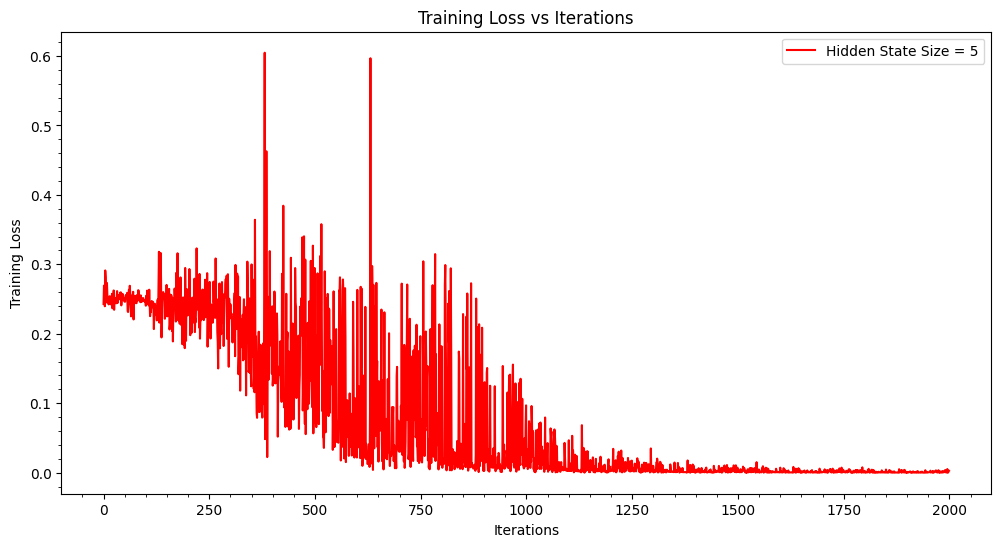

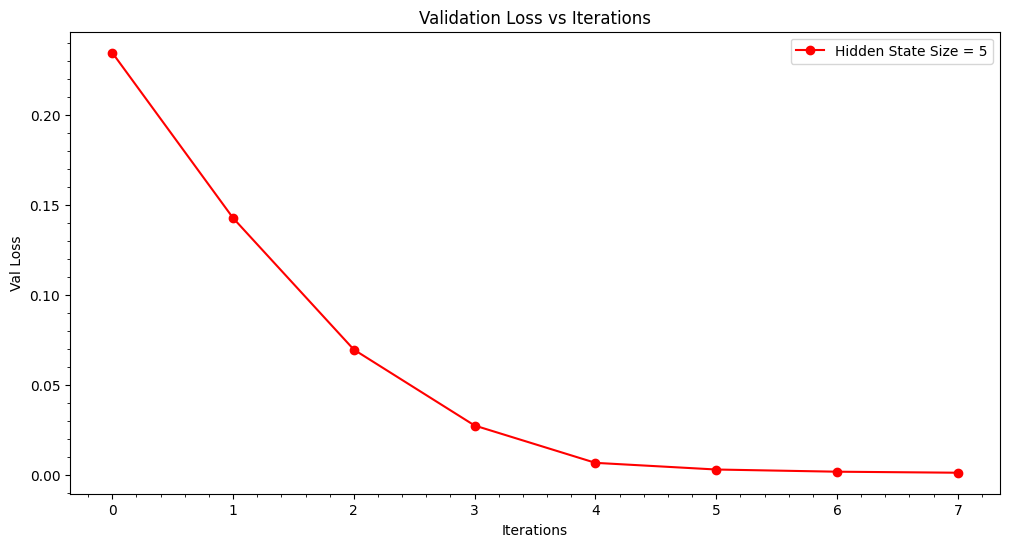

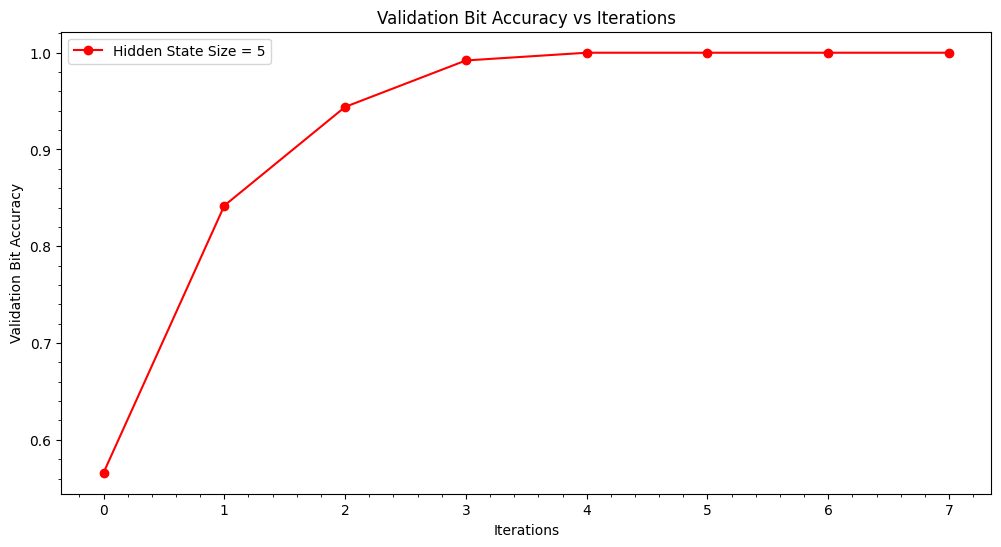

In [69]:
plotter(train_loss_bin, val_loss_bin, val_accuracy_bin, hs_bin, "red")

In [70]:
evaluate_model(model_bin, test_X, test_Y, hs_bin, device)

Accuracy for number of hidden states = 5: 99.90 %


## 2.3 Experiments
### Vary the state vector size and check if there is any improvement in bit-accuracy

1. Hidden state = 3

In [71]:
learning_rate = 0.01
epochs = 8

hs_bin = 3

criterion_bin_test1 = nn.MSELoss()
model_bin_test1 = LSTM_Binary(hs_bin, device)
optimizer_bin_test1 = torch.optim.Adam(model_bin_test1.parameters(), lr=learning_rate)

train_loss_bin_test1, val_loss_bin_test1, val_accuracy_bin_test1 = train_model(model_bin_test1, train_X, val_X, train_Y, val_Y, criterion_bin_test1, optimizer_bin_test1, num_epochs=epochs, device=device)

print("")

evaluate_model(model_bin_test1, test_X, test_Y, hs_bin, device)

Epoch [1/8] - Validation loss: 0.2284, Validation accuracy: 59.40%
Epoch [2/8] - Validation loss: 0.1508, Validation accuracy: 83.60%
Epoch [3/8] - Validation loss: 0.0958, Validation accuracy: 88.80%
Epoch [4/8] - Validation loss: 0.0622, Validation accuracy: 94.80%
Epoch [5/8] - Validation loss: 0.0254, Validation accuracy: 98.40%
Epoch [6/8] - Validation loss: 0.0143, Validation accuracy: 99.20%
Epoch [7/8] - Validation loss: 0.0083, Validation accuracy: 99.80%
Epoch [8/8] - Validation loss: 0.0049, Validation accuracy: 100.00%

Accuracy for number of hidden states = 3: 97.41 %


2. Hidden state = 8

In [72]:
learning_rate = 0.01
epochs = 8

hs_bin = 8

criterion_bin_test2 = nn.MSELoss()
model_bin_test2 = LSTM_Binary(hs_bin, device)
optimizer_bin_test2 = torch.optim.Adam(model_bin_test2.parameters(), lr=learning_rate)

train_loss_bin_test2, val_loss_bin_test2, val_accuracy_bin_test2 = train_model(model_bin_test2, train_X, val_X, train_Y, val_Y, criterion_bin_test2, optimizer_bin_test2, num_epochs=epochs, device=device)

print("")

evaluate_model(model_bin_test2, test_X, test_Y, hs_bin, device)

Epoch [1/8] - Validation loss: 0.2211, Validation accuracy: 62.40%
Epoch [2/8] - Validation loss: 0.0932, Validation accuracy: 91.60%
Epoch [3/8] - Validation loss: 0.0240, Validation accuracy: 100.00%
Epoch [4/8] - Validation loss: 0.0082, Validation accuracy: 100.00%
Epoch [5/8] - Validation loss: 0.0040, Validation accuracy: 100.00%
Epoch [6/8] - Validation loss: 0.0024, Validation accuracy: 100.00%
Epoch [7/8] - Validation loss: 0.0015, Validation accuracy: 100.00%
Epoch [8/8] - Validation loss: 0.0010, Validation accuracy: 100.00%

Accuracy for number of hidden states = 8: 100.00 %


3. Hidden size = 10

In [73]:
learning_rate = 0.01
epochs = 8

hs_bin = 10

criterion_bin_test3 = nn.MSELoss()
model_bin_test3 = LSTM_Binary(hs_bin, device)
optimizer_bin_test3 = torch.optim.Adam(model_bin_test3.parameters(), lr=learning_rate)

train_loss_bin_test3, val_loss_bin_test3, val_accuracy_bin_test3 = train_model(model_bin_test3, train_X, val_X, train_Y, val_Y, criterion_bin_test3, optimizer_bin_test3, num_epochs=epochs, device=device)

print("")

evaluate_model(model_bin_test3, test_X, test_Y, hs_bin, device)

Epoch [1/8] - Validation loss: 0.2063, Validation accuracy: 68.40%
Epoch [2/8] - Validation loss: 0.0515, Validation accuracy: 94.80%
Epoch [3/8] - Validation loss: 0.0190, Validation accuracy: 100.00%
Epoch [4/8] - Validation loss: 0.0061, Validation accuracy: 100.00%
Epoch [5/8] - Validation loss: 0.0026, Validation accuracy: 100.00%
Epoch [6/8] - Validation loss: 0.0014, Validation accuracy: 100.00%
Epoch [7/8] - Validation loss: 0.0009, Validation accuracy: 100.00%
Epoch [8/8] - Validation loss: 0.0006, Validation accuracy: 100.00%

Accuracy for number of hidden states = 10: 100.00 %


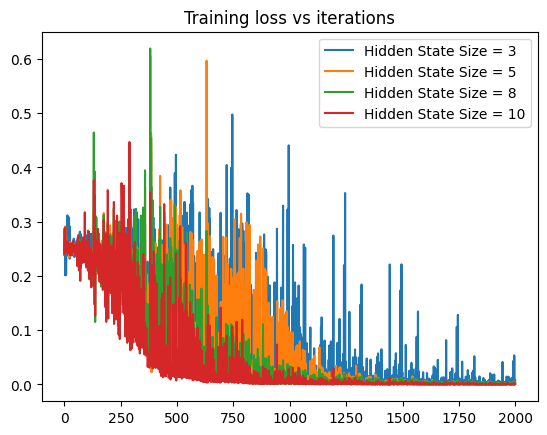

In [74]:
xlist=np.arange(len(train_loss_bin))
plt.plot(xlist,train_loss_bin_test1,label="Hidden State Size = 3")
plt.plot(xlist,train_loss_bin,label="Hidden State Size = 5")
plt.plot(xlist,train_loss_bin_test2,label="Hidden State Size = 8")
plt.plot(xlist,train_loss_bin_test3,label="Hidden State Size = 10")
plt.legend()
plt.title("Training loss vs iterations")
plt.show()

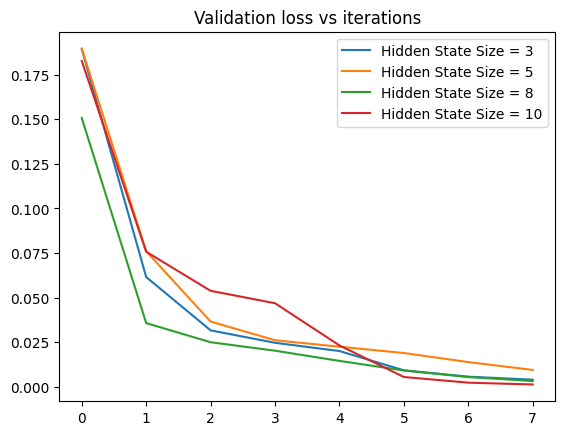

In [ ]:
xlist=np.arange(len(val_loss_bin))
plt.plot(xlist,val_loss_bin_test1,label="Hidden State Size = 3")
plt.plot(xlist,val_loss_bin,label="Hidden State Size = 5")
plt.plot(xlist,val_loss_bin_test2,label="Hidden State Size = 8")
plt.plot(xlist,val_loss_bin_test3,label="Hidden State Size = 10")
plt.legend()
plt.title("Validation loss vs iterations")
plt.show()

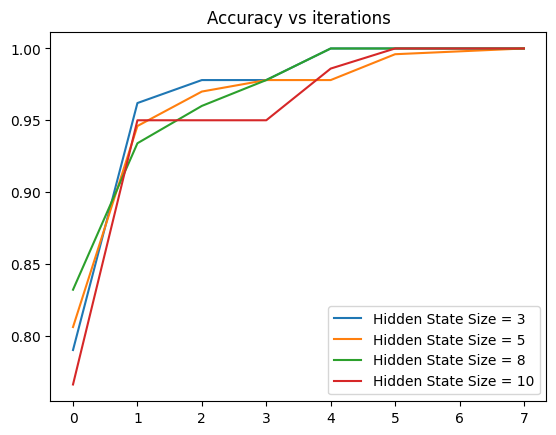

In [ ]:
xlist=np.arange(len(val_accuracy_bin))
plt.plot(xlist,val_accuracy_bin_test1,label="Hidden State Size = 3")
plt.plot(xlist,val_accuracy_bin,label="Hidden State Size = 5")
plt.plot(xlist,val_accuracy_bin_test2,label="Hidden State Size = 8")
plt.plot(xlist,val_accuracy_bin_test3,label="Hidden State Size = 10")
plt.legend()
plt.title("Accuracy vs iterations")
plt.show()

| Model | Hidden state | Test Accuracy |
| --- | --- | --- |
| model_bin_test1 | 3 | 97.41 % |
| model_bin | 5 | 99.90 % |
| model_bin_test2 | 8 | 100.00 % |
| model_bin_test3 | 10 | 100.00 % |

Larger hidden states increase the model's capacity, allowing it to learn more complex patterns in the data. However, since the training and validation datasets have a fixed vector length (5), a larger model may overfit to this specific length. Moreover, a model trained with smaller hidden states tends to generalize better because it has a simpler structure, which can act as a regularizer (it is the same idea of a autoencoder).

PS: by running the training several times I realized that most of the times it was due to randomness. Anyway I believe it's an interesting thing to test with maybe larger dataset (this experiment is pretty simple).

### Compare the accuracies on using MSE and Cross-Entropy loss functions separately

In [ ]:
learning_rate = 0.01
epochs = 8

hs_bin = 5

criterion_bin_test4 = nn.CrossEntropyLoss()
model_bin_test4 = LSTM_Binary(hs_bin, device)
optimizer_bin_test4 = torch.optim.Adam(model_bin_test4.parameters(), lr=learning_rate)

train_loss_bin_test4, val_loss_bin_test4, val_accuracy_bin_test4 = train_model(model_bin_test4, train_X, val_X, train_Y, val_Y, criterion_bin_test4, optimizer_bin_test4, num_epochs=epochs, device=device)

print("")

evaluate_model(model_bin_test4, test_X, test_Y, hs_bin, device)

Epoch [1/8] - Validation loss: 3.3620, Validation accuracy: 65.20%
Epoch [2/8] - Validation loss: 2.9551, Validation accuracy: 92.60%
Epoch [3/8] - Validation loss: 2.8992, Validation accuracy: 93.80%
Epoch [4/8] - Validation loss: 2.8820, Validation accuracy: 93.80%
Epoch [5/8] - Validation loss: 2.8751, Validation accuracy: 93.80%
Epoch [6/8] - Validation loss: 2.8717, Validation accuracy: 93.80%
Epoch [7/8] - Validation loss: 2.8697, Validation accuracy: 93.80%
Epoch [8/8] - Validation loss: 2.8685, Validation accuracy: 93.80%

Accuracy for number of hidden states = 5: 90.78 %


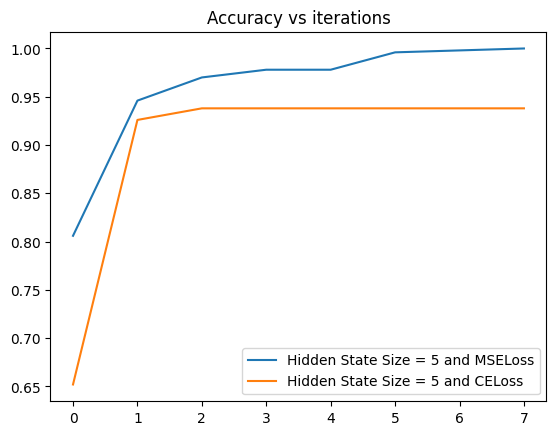

In [ ]:
xlist=np.arange(len(val_accuracy_bin))
plt.plot(xlist,val_accuracy_bin,label="Hidden State Size = 5 and MSELoss")
plt.plot(xlist,val_accuracy_bin_test4,label="Hidden State Size = 5 and CELoss")
plt.legend()
plt.title("Accuracy vs iterations")
plt.show()

I tried to run many times the training of the model. Sometimes it gets good result but most of the times it gets stuck and does not perform well.
So, the total loss is the sum of the loss functions at every time step. Therefore the output is essentially a binary classification (0 or 1). MSE fits naturally here as it directly measures how close each output bit is to the desired bit, adjusting the weights smoothly.
With Cross Entropy Loss, the model may struggle because it expects discrete, mutually exclusive classes, and it often results in overly confident predictions, which might not suit the binary output structure in this task.

### Train only on a fixed length inputs say L = 3, L = 5, L = 10 and check the bit-accuracy on different lengths. What do you observe?

In [ ]:
L = 3
train_X, train_Y, val_X, val_Y, test_X, test_Y = generate_datasets(L)

learning_rate = 0.01
epochs = 8

hs_bin = 5 # I kept hidden state = 5!

criterion_bin_L3 = nn.MSELoss()
model_bin_L3 = LSTM_Binary(hs_bin, device)
optimizer_bin_L3 = torch.optim.Adam(model_bin_L3.parameters(), lr=learning_rate)

train_loss_bin_L3, val_loss_bin_L3, val_accuracy_bin_L3 = train_model(model_bin_L3, train_X, val_X, train_Y, val_Y, criterion_bin_L3, optimizer_bin_L3, num_epochs=epochs, device=device)

print("")

evaluate_model(model_bin_L3, test_X, test_Y, hs_bin, device)

Epoch [1/8] - Validation loss: 0.1654, Validation accuracy: 88.00%
Epoch [2/8] - Validation loss: 0.0909, Validation accuracy: 91.33%
Epoch [3/8] - Validation loss: 0.0673, Validation accuracy: 94.00%
Epoch [4/8] - Validation loss: 0.0620, Validation accuracy: 94.00%
Epoch [5/8] - Validation loss: 0.0592, Validation accuracy: 94.00%
Epoch [6/8] - Validation loss: 0.0446, Validation accuracy: 94.00%
Epoch [7/8] - Validation loss: 0.0356, Validation accuracy: 96.67%
Epoch [8/8] - Validation loss: 0.0345, Validation accuracy: 96.67%

Accuracy for number of hidden states = 5: 74.75 %


In [ ]:
L = 5
train_X, train_Y, val_X, val_Y, test_X, test_Y = generate_datasets(L)

learning_rate = 0.01
epochs = 8

hs_bin = 5 # I kept hidden state = 5!

criterion_bin_L5 = nn.MSELoss()
model_bin_L5 = LSTM_Binary(hs_bin, device)
optimizer_bin_L5 = torch.optim.Adam(model_bin_L5.parameters(), lr=learning_rate)

train_loss_bin_L5, val_loss_bin_L5, val_accuracy_bin_L5 = train_model(model_bin_L5, train_X, val_X, train_Y, val_Y, criterion_bin_L5, optimizer_bin_L5, num_epochs=epochs, device=device)

print("")

evaluate_model(model_bin_L5, test_X, test_Y, hs_bin, device)

Epoch [1/8] - Validation loss: 0.2210, Validation accuracy: 67.20%
Epoch [2/8] - Validation loss: 0.0822, Validation accuracy: 84.80%
Epoch [3/8] - Validation loss: 0.0467, Validation accuracy: 90.20%
Epoch [4/8] - Validation loss: 0.0180, Validation accuracy: 100.00%
Epoch [5/8] - Validation loss: 0.0063, Validation accuracy: 100.00%
Epoch [6/8] - Validation loss: 0.0034, Validation accuracy: 100.00%
Epoch [7/8] - Validation loss: 0.0021, Validation accuracy: 100.00%
Epoch [8/8] - Validation loss: 0.0015, Validation accuracy: 100.00%

Accuracy for number of hidden states = 5: 100.00 %


In [ ]:
L = 10
train_X, train_Y, val_X, val_Y, test_X, test_Y = generate_datasets(L)

learning_rate = 0.01
epochs = 8

hs_bin = 5 # I kept hidden state = 5!

criterion_bin_L10 = nn.MSELoss()
model_bin_L10 = LSTM_Binary(hs_bin, device)
optimizer_bin_L10 = torch.optim.Adam(model_bin_L10.parameters(), lr=learning_rate)

train_loss_bin_L10, val_loss_bin_L10, val_accuracy_bin_L10 = train_model(model_bin_L10, train_X, val_X, train_Y, val_Y, criterion_bin_L10, optimizer_bin_L10, num_epochs=epochs, device=device)

print("")

evaluate_model(model_bin_L10, test_X, test_Y, hs_bin, device)

Epoch [1/8] - Validation loss: 0.2480, Validation accuracy: 55.10%
Epoch [2/8] - Validation loss: 0.2426, Validation accuracy: 55.30%
Epoch [3/8] - Validation loss: 0.1639, Validation accuracy: 74.10%
Epoch [4/8] - Validation loss: 0.0624, Validation accuracy: 88.50%
Epoch [5/8] - Validation loss: 0.0336, Validation accuracy: 100.00%
Epoch [6/8] - Validation loss: 0.0128, Validation accuracy: 100.00%
Epoch [7/8] - Validation loss: 0.0062, Validation accuracy: 100.00%
Epoch [8/8] - Validation loss: 0.0034, Validation accuracy: 100.00%

Accuracy for number of hidden states = 5: 100.00 %


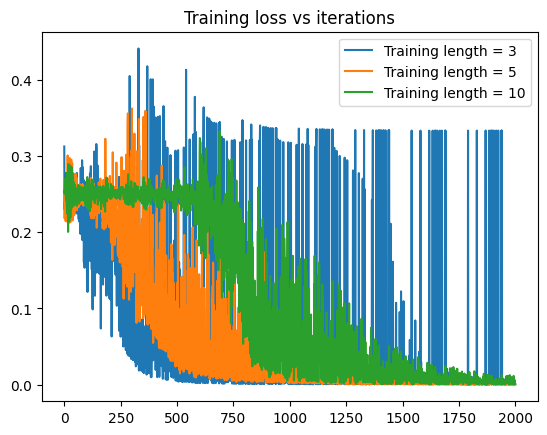

In [ ]:
xlist=np.arange(len(train_loss_bin))
plt.plot(xlist,train_loss_bin_L3,label="Training length = 3")
plt.plot(xlist,train_loss_bin_L5,label="Training length = 5")
plt.plot(xlist,train_loss_bin_L10,label="Training length = 10")
plt.legend()
plt.title("Training loss vs iterations")
plt.show()

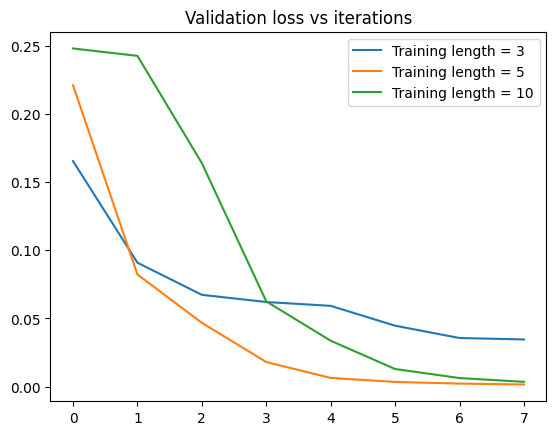

In [ ]:
xlist=np.arange(len(val_loss_bin))
plt.plot(xlist,val_loss_bin_L3,label="Training length = 3")
plt.plot(xlist,val_loss_bin_L5,label="Training length = 5")
plt.plot(xlist,val_loss_bin_L10,label="Training length = 10")
plt.legend()
plt.title("Validation loss vs iterations")
plt.show()

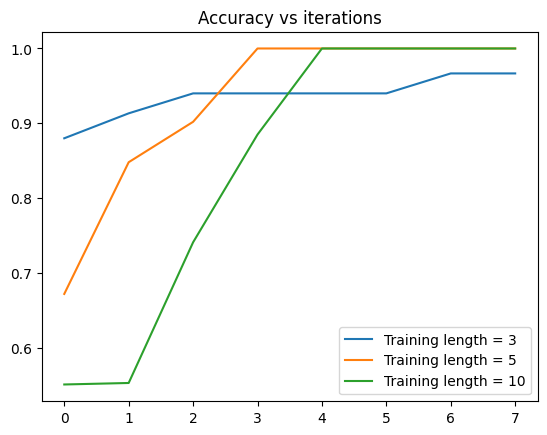

In [ ]:
xlist=np.arange(len(val_accuracy_bin))
plt.plot(xlist,val_accuracy_bin_L3,label="Training length = 3")
plt.plot(xlist,val_accuracy_bin_L5,label="Training length = 5")
plt.plot(xlist,val_accuracy_bin_L10,label="Training length = 10")
plt.legend()
plt.title("Accuracy vs iterations")
plt.show()

We can see two different behaviors here:

1. Model Not Converging/Bad results with Length = 3:

When trained with very short sequences (length = 3), the model receives limited information on sequence structure, which may make it harder for the LSTM to learn meaningful patterns, such as the carry-over behavior in binary addition. Therefore, the LSTM may struggle to generalize, as it has insufficient sequence complexity to grasp.

2. Faster Convergence with Length = 5 than Length = 10:

When training with longer sequences (e.g., length = 10), the model has to learn and remember dependencies over more time steps. LSTMs handle longer dependencies better than simpler RNNs, but longer sequences can still slow convergence due to the need for the model to process and propagate information across more layers. This leads to slower training as the model adapts to longer-range dependencies.

## References
### General
https://www.cse.iitm.ac.in/~miteshk/CS7015_2018.html </br>
https://www.youtube.com/watch?v=6niqTuYFZLQ&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=10 </br>

### RNN
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html </br>
https://www.digitalocean.com/community/tutorials/bidirectional-rnn-keras#the-need-for-bidirectional-traversal

### LSTM
https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ </br>
https://github.com/InFoCusp/lstm_deepdive/blob/master/Binary%20Addition%20using%20LSTM.ipynb